# 案例2 - 共享单车需求预测


## 1. 项目数据

**数据来源**：本案例的项目数据来自[D.C.华盛顿首都自行车共享需求预测项目](https://www.capitalbikeshare.com/system-data)

**数据文件**：bike.csv

**数据集描述**：

字段名|中文含义|字段描述
-----|-------|------
datetime|日期|年月日时分秒
season|季节|1=spring,2=summer,3=fail,4=winter
holiday|是否假日|1:是，0:否
workingday|是否工作日|1:是，0:否
weather|天气等级|1:晴天，多云，少云  2: 雾，阴  3: 小雨，小雪  4: 暴雨，大雪
temp|温度|
atemp|体感温度|
humidity|相对湿度|
windspeed|风速|
casual|临时租赁数量|
registered|会员租赁数量|
count|总租赁数量|



## 2. 分析目标

本案例综合python数据分析和可视化，形成完整的python数据分析项目报告。


## 3. 分析过程

下面根据数据分析的步骤对本案例项目一一展开分析。

 1. 提出问题
 2. 理解数据
 3. 清洗数据
 4. 数据分析
 5. 提取特征
 6. 构建模型
 7. 评估模型
 8. 项目预测
 
### 3.1 提出问题

通过历史用车记录结合天气等数据预测共享单车项目在华盛顿的租赁数量：临时租赁数量、会员租赁数据、总租赁数量。

### 3.2 理解数据

#### （1）导入数据分析与可视化包

In [1]:
# 导入数据分析与可视化包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# 关闭警告
import warnings
warnings.filterwarnings('ignore')

#### （2）导入数据集

In [2]:
bikes = pd.read_csv('bike.csv')
bikes.shape

(10886, 12)

#### （3）查看数据集

##### 1、查看数据集的大小

In [3]:
print('数据集大小：', bikes.shape)
print('数据集的列名：\n', bikes.columns)

数据集大小： (10886, 12)
数据集的列名：
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


**分析**：数据集大小为10886行12列。其中，‘casual'、'registered'、'count'这3列数据正是本文需要通过模型预测的。

##### 2、查看数据集的内容

In [4]:
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


##### 3、查看数据集是否有缺失值

In [5]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


**分析**：整个数据集没有缺失值

##### 4、查看数据集有无异常值

In [6]:
bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


**分析**：count列的标准差最大，反应出这列的数据差异较大

### 3.3 清洗数据

#### （1）缺失值填充

本数据集无缺失值，无需填充缺失值

#### （2）异常值处理

##### 1、数据集中数值类型异常值处理

通过上述descirbe查看数值类型数据，了解到数据集中‘count’这列数值差异较大。接下来对数据集中‘count'列进行清洗。

先可视化'count'列的分布情况：

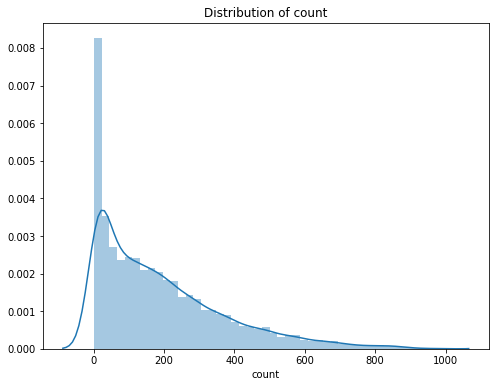

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

fig.set_size_inches(8, 6)
sns.distplot(bikes['count'])
ax.set(xlabel='count', title='Distribution of count')

plt.show()

**分析**：分布偏斜较为严重。先排除掉3倍于标准差以外的数据，代码如下：

In [8]:
bikes_clean = bikes[np.abs(bikes['count'] - bikes['count'].mean())\
                    <= (3 * bikes['count']\
                           .std())]
bikes_clean.shape             

(10739, 12)

**分析**：查看排除3倍于标准差以外的数据后的'count'分布，代码如下：

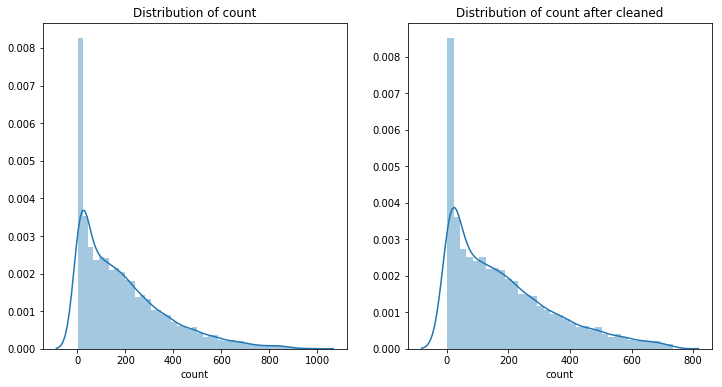

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.set_size_inches(12, 6)

sns.distplot(bikes['count'], ax = ax1)
sns.distplot(bikes_clean['count'], ax = ax2)

ax1.set(xlabel='count', title='Distribution of count')
ax2.set(xlabel='count', title="Distribution of count after cleaned")

plt.show()

**分析**：可见，'count'数据波动依然很大，此时需要对数据进行变换，使得数据相对稳定，选择对数变换获取稳定数据，代码如下：

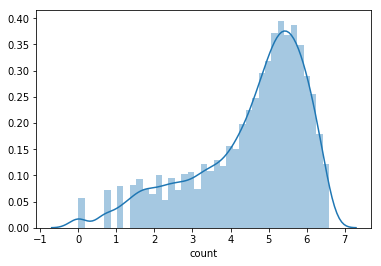

In [10]:
ylabel = bikes_clean['count']
ylabel_log = np.log(ylabel)

sns.distplot(ylabel_log)

plt.show()

**分析**：经过对数变换后数据分布更均匀，大小差异也缩小了，使用这样的标签对训练模型是有益的。

##### 2、数据集中日期和数值类型转换

数据集中除时间列数据为字符串外其余都为数值型数据：时间的数据格式需要转换为时间序列，进一步处理得到日期和星期的时间数据。

1. 日期类型转换

   - 函数astype：整型转换；
   - 函数isoweekday：转换日期对应的周末；
   - 函数strptime：strptime是python datetime库中的函数，用于将一个日期字符串转成datetime日期格式便于后期处理，使用格式为 datetime.strptime(date_string, format) ，其中date_string 就是要转成日期的字符串，format 根据date_string 不同而不同。

   为了方便查可视化数据，需要把datetime拆分成成日期、时段、年份、月份、星期五列，代码如下：

In [11]:
bikes['date'] = bikes.datetime.apply(lambda dt: dt.split()[0])
bikes['year'] = bikes.datetime.apply(lambda dt: dt.split()[0].split('-')[0]).astype('int')
bikes['month'] = bikes.datetime.apply(lambda dt: dt.split()[0].split('-')[1]).astype(int)
bikes['hour'] = bikes.datetime.apply(lambda dt: dt.split()[1].split(':')[0]).astype(int)
bikes['weekday'] = bikes.date.apply(lambda dt: datetime.strptime(dt, '%Y-%m-%d').isoweekday())

bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,1,0,6
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,1,1,6
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,1,2,6
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,1,3,6
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,1,4,6


2. 日期类型转换

   观察上面的数据发现temp（温度），atemp（体感温度），humidity（湿度），windspeed（风速）这四列也属于数值型数据，同样可以查看一下它们的密度分布，代码如下：

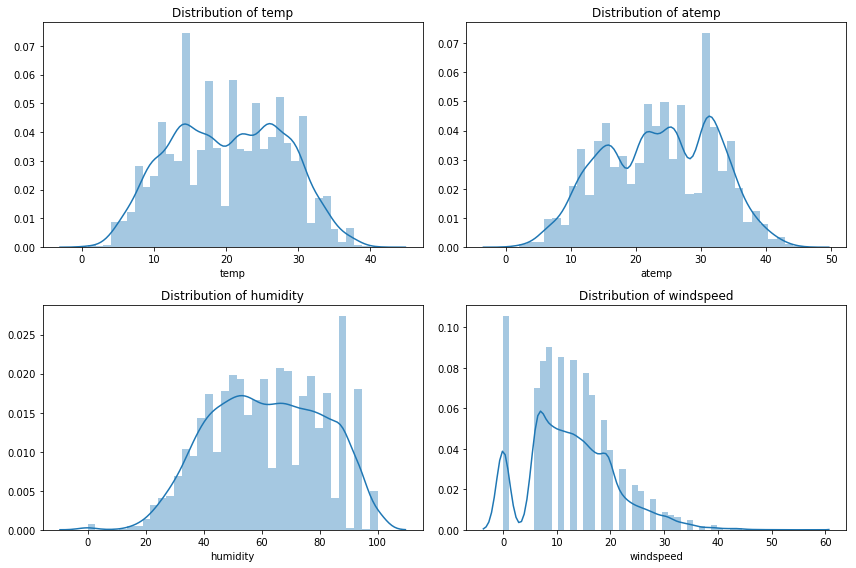

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 8)

sns.distplot(bikes['temp'], ax=axs[0,0])
sns.distplot(bikes['atemp'], ax=axs[0,1])
sns.distplot(bikes['humidity'], ax=axs[1,0])
sns.distplot(bikes['windspeed'], ax=axs[1,1])

axs[0,0].set(xlabel='temp', title='Distribution of temp')
axs[0,1].set(xlabel='atemp', title='Distribution of atemp')
axs[1,0].set(xlabel='humidity', title='Distribution of humidity')
axs[1,1].set(xlabel='windspeed', title='Distribution of windspeed')

plt.tight_layout()

plt.show()

**分析**：上图中显示'windspeed'中为0的数值较多，通过统计描述进一步查看空缺值，如下：

In [13]:
bikes['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

上述描述统计中发现，'windspeed'中没有空缺值，但是min为0，这是不符合常识的，即风速不可能为0。这说明'windspeed'风速数据空缺值用0进行了填充，而这些风速为0的数据会对预测产生干扰，将使用随机森林模型根据相同的年份、月份、季节、温度、湿度等几个特征来填充一下风速的缺失值，即取代风速为0的值。

填充之前查看非零数据的'windspeed'描述统计，代码如下：

In [14]:
bikes[bikes['windspeed'] > 0]['windspeed'].describe()

count    9573.000000
mean       14.554917
std         7.088674
min         6.003200
25%         8.998100
50%        12.998000
75%        19.001200
max        56.996900
Name: windspeed, dtype: float64

In [15]:
10886-9573

1313

**分析**：可见，风速为0的数据个数为10886-9573=1312个。

接下来使用将使用**随机森林模型**根据相同的年份、月份、季节、温度、湿度等几个特征来填充一下风速的缺失值，代码如下：

In [16]:
from sklearn.ensemble import RandomForestRegressor
# 新增一列，存放处理后的windspeed
bikes['windspeed_RFR'] = bikes['windspeed']
# 将数据分成风速为0和不为0的两部分，以将不为0的部分用随机森林模型预测的值进行替代
windspeed_zero = bikes[bikes['windspeed_RFR']==0]
windspeed_not_zero = bikes[bikes['windspeed_RFR']!=0]

# 创建模型
rfr_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# 选择特征
feature_cols = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

# 将风速不为0的数据作为训练数据集，拟合到RandomForestRegressor中
rfr_model.fit(windspeed_not_zero[feature_cols], windspeed_not_zero['windspeed_RFR'])

# 利用训练好的模型预测风速
predicted_windspeed = rfr_model.predict(X=windspeed_zero[feature_cols])

# 将预测结果填充到风速为0的数据中
windspeed_zero.loc[:,'windspeed_RFR'] = predicted_windspeed

# 连接两部分数据
bikes_clean = windspeed_not_zero.append(windspeed_zero)
bikes_clean.reset_index(inplace=True)
bikes_clean.drop('index', inplace=True, axis=1)

**分析**：可视化风速为0的值被随机森林模型预测值代替后的数据，代码如下：

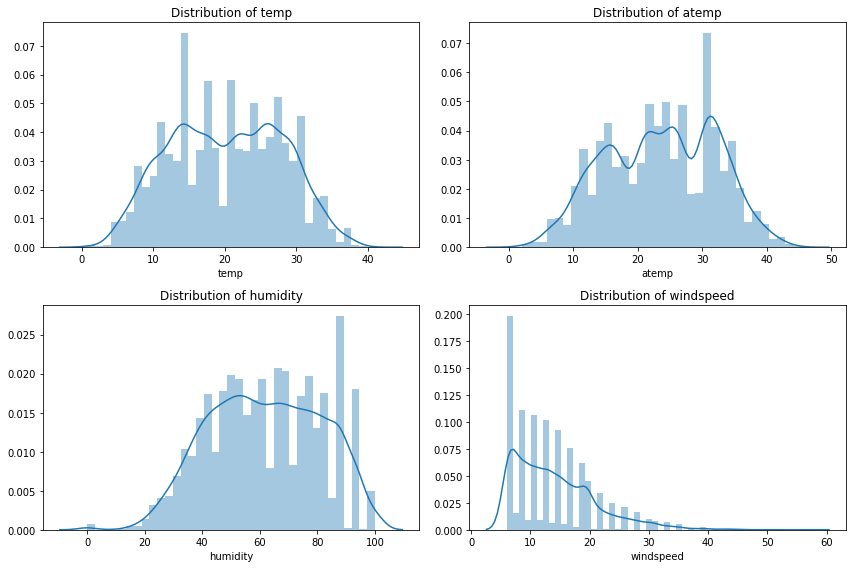

In [17]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 8)

sns.distplot(bikes_clean['temp'], ax=axs[0,0])
sns.distplot(bikes_clean['atemp'], ax=axs[0,1])
sns.distplot(bikes_clean['humidity'], ax=axs[1,0])
sns.distplot(bikes_clean['windspeed_RFR'], ax=axs[1,1])

axs[0,0].set(xlabel='temp', title='Distribution of temp')
axs[0,1].set(xlabel='atemp', title='Distribution of atemp')
axs[1,0].set(xlabel='humidity', title='Distribution of humidity')
axs[1,1].set(xlabel='windspeed', title='Distribution of windspeed')

plt.tight_layout()

plt.show()

对比使用随机森林模型预测值取代风速为0后的'windspeed'与原'windspeed'的描述统计信息，检查原'windspeed'中为0的部分是否已填充好：

In [18]:
bikes_clean[['windspeed', 'windspeed_RFR']].describe()

,windspeed,windspeed_RFR
count,10886.000000,10886.000000
mean,12.799395,14.083317
std,8.164537,6.908075
min,0.000000,6.003200
25%,7.001500,8.998100
50%,12.998000,12.998000
75%,16.997900,18.740041
max,56.996900,56.996900


**分析**：可见，通过随机森林已完成缺失值的填充。

至此，数据清洗操作已完成，接下来对项目进行数据分析。

### 3.4 分析数据

#### （1）总租赁数量count分析

1. 第一步：先观察两年时间里，总租车数量随时间变化的情况

   - 函数groupby：按行聚合
   - 函数agg：按列聚合
   - 函数dropna：删除空缺值
   - matplotlib绘图：折线图plt.plot(X,Y,marker标记,linewidth长度,label图名称)
   - plt.plot(count_month\['date'\],count_month\['count'\],marker='^',linewidth=2,label='Monthly average')
   - seaborn绘图：折线图sns.kdeplot(X)

In [20]:
# 按天求和
count_day = bikes_clean.groupby(['date', 'weekday'], as_index=False)
count_day = count_day.agg({'year':'mean', 'month':'mean', 'casual':'sum', 'registered':'sum', 'count':'sum'})
count_day.dropna(axis=0, how='any', inplace=True)

# 按月取平均数
count_month=count_day.groupby(['year', 'month'], as_index=False)
count_month = count_month.agg({'weekday':'min', 'casual':'mean', 'registered':'mean', 'count':'mean'})

# 将按天求和的日期转换为datetime格式
count_day['date'] = pd.to_datetime(count_day['date'])
count_month.rename(columns={'weekday':'day'}, inplace=True)
count_month['date'] = pd.to_datetime(count_month[['year','month','day']])

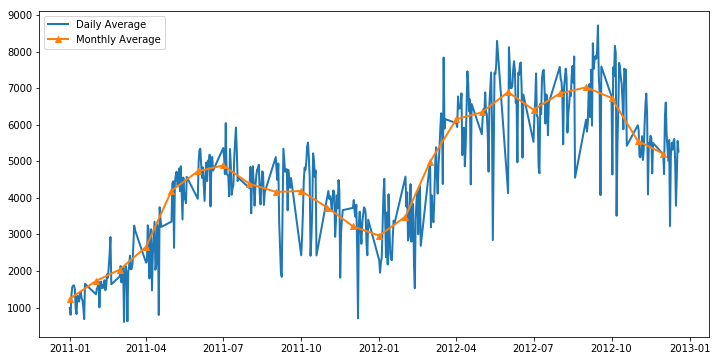

In [21]:
# 使用折线图显示总体租赁情况随时间的走势
plt.figure(figsize=(12, 6))

plt.plot(count_day['date'], count_day['count'], lw=2, label='Daily Average')
ax.set_title('Change Trend of Average Number of Rentals initiated per Day in 2 years')
plt.plot(count_month['date'], count_month['count'], marker='^', lw=2, label='Monthly Average')

plt.legend()

plt.show()

**分析**：从上图可以看出总租赁数量呈逐渐递增趋势，明显2012年总租赁数量大于2011年。

#### （2）整体观察

目标是希望预测每小时总租赁额，首先整体看一下租赁数量和其他特征值的关系。

- 函数pairplot：seaborn中pairplot函数用来可视化探索数据特征间的关系

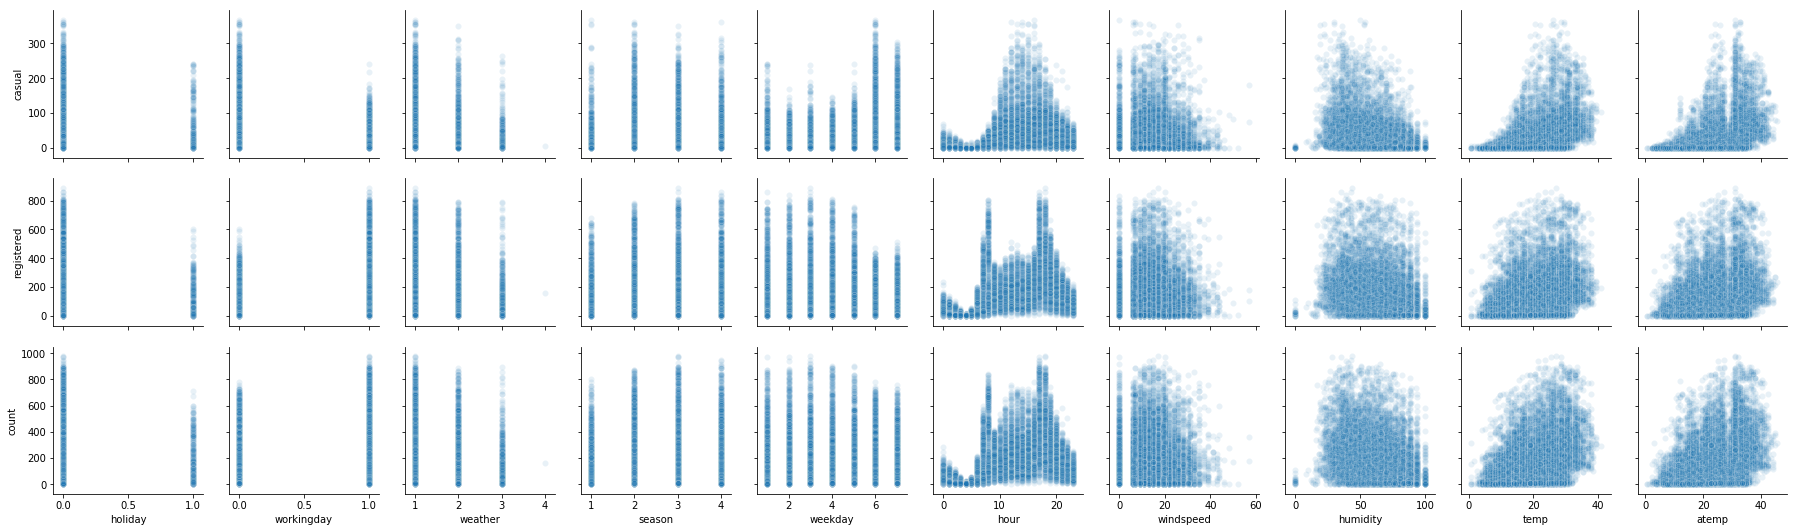

In [22]:
sns.pairplot(bikes_clean, x_vars=['holiday','workingday','weather','season','weekday',
                                  'hour','windspeed','humidity','temp','atemp' ],
            y_vars=['casual', 'registered', 'count'], plot_kws={'alpha': 0.1})
plt.show()

**分析**：

- 节假日/工作日（holiday/workingday/weekday）：会员工作日使用自行车较多，节假日用得少，而非会员则相反，节假日用得多工作日用得少；
- 天气（weather）：在天气恶劣情况下，几乎没人使用自行车，天气越好则使用越好；
- 季节（season）：一年四季中夏天使用自行车的人最多，有个特别现象是冬天使用人数比春天多，这有可能与欧洲初春比较冷有关；
- 时段（hour）：一天中会员使用自行车数量呈现2个高峰期，可能是处于上下班时段，而非会员使用自行车数量呈现正态分布；
- 风速（windspeed）：人们选择使用自行车也会考虑风速，风越大越不方便使用自行车；
- 湿度/温度（humidity/temp/atemp）：湿度和温度对非会员影响比较明显，对会员影响不大；

接下来对上述各影响因素对自行车使用数量的影响程度进行量化。

#### （3）各影响因素的相关性

1. 相关性系数

   - 函数corr：相关性系数

In [23]:
corr_df = bikes.corr()
corr_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday,windspeed_RFR
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.004797,0.971524,-0.006546,-0.010553,-0.147121
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.000354,-0.191832,0.008409
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.002780,-0.704267,0.013373
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.022740,-0.047692,0.007261
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.145430,-0.038466,-0.017852
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.140343,-0.040235,-0.057473
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.278011,-0.026507,-0.318607
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.146631,-0.024804,1.000000
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.302045,0.246959,0.092276
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.264265,0.169451,0.380540,-0.084427,0.091052


2. 相关性可视化

   绘制相关系数热度图：（热图能展现各影响因素之间的影响强弱）
   
   - seaborn绘图：热图 sns.heatmap
   - sns.heatmap(corrDf,ax=ax1,vmax=1,square=False,annot=True,cmap='YlGnBu',linewidths=.5)


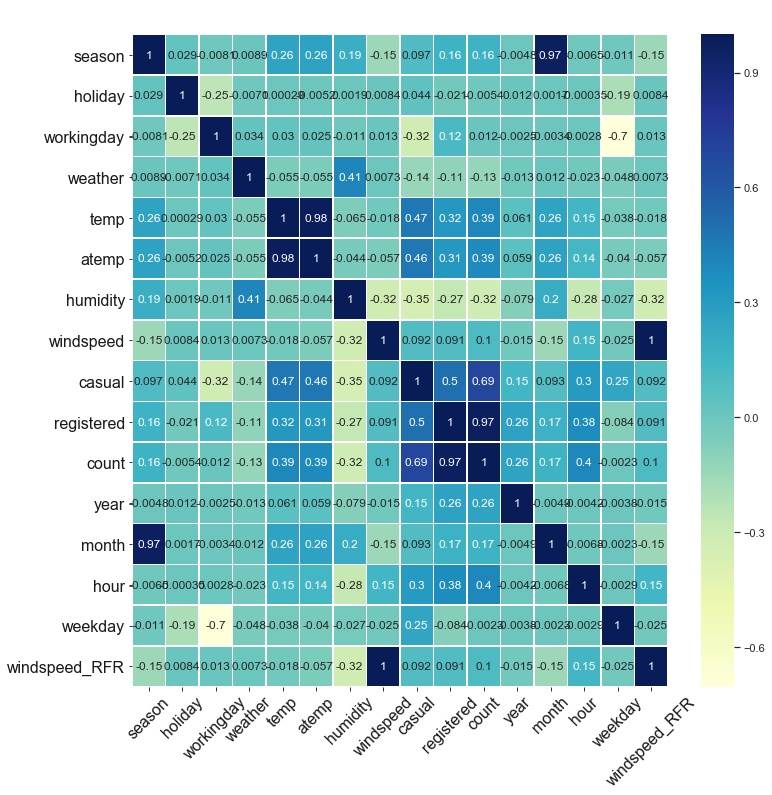

In [24]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
sns.set(style='dark')
sns.heatmap(corr_df, ax=ax, vmax=1, square=False, annot=True, cmap='YlGnBu', lw=0.5)

plt.title('Heatmap on Correlation', fontsize=30, color='w')
plt.xticks(fontsize=16, color='k', rotation=45)
plt.yticks(fontsize=16, color='k')

plt.show()

3. 相关性强弱对比

   本案例主要分析的是上述各影响因素对自行车租赁数量影响程度。接下来获取count与各元素之间的相关性。

In [25]:
corr_df['count'].sort_values(ascending=False)

count            1.000000
registered       0.970948
casual           0.690414
hour             0.400601
temp             0.394454
atemp            0.389784
year             0.260403
month            0.166862
season           0.163439
windspeed_RFR    0.101369
windspeed        0.101369
workingday       0.011594
weekday         -0.002283
holiday         -0.005393
weather         -0.128655
humidity        -0.317371
Name: count, dtype: float64

**分析**：

上述各影响因素对租赁数量的影响力度为：
- hour>temp>atemp>year>month>season>windspeed>weekday>holiday>working>weather>humidity
- 即：时段>温度>体感温度>年份>月份>季节>风速>星期几>是否假日>是否工作日>天气等级>湿度；
- 正相关影响因素：时段、温度、体感温度、年份、月份、季节、风速、星期几、是否假日；
- 负相关影响因素：是否工作日、天气等级、湿度；

接下来逐个分析上述各影响因素对租赁数量的影响。

#### （4）逐个分析各影响因素对租赁数量的影响

由上述分析，可知影响租赁数量的因素有如下几种：

时段、温度、体感温度、年份、月份、季节、风速、星期、是否假日、是否工作日、天气等级、湿度。

其中，分类变量为：时段、月份、季节、天气、星期、是否工作日、是否节假日。

- 可离散化变量：时段、月份、季节、星期

- 连续变量：温度、体感温度、湿度

接下来按照上述分类分别绘制相应的可视化图。

##### 1. 各分类变量对租赁数量的可视化分析

1. **分类变量离散化**

① 季节变量离散化

In [26]:
season_dict = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
bikes_clean['season_category'] = bikes_clean['season'].map(season_dict)
#bikes_clean[['season','season_category']].head()
bikes_clean.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday,windspeed_RFR,season_category
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011-01-01,2011,1,5,6,6.0032,spring
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011-01-01,2011,1,10,6,16.9979,spring
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011-01-01,2011,1,11,6,19.0012,spring
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011-01-01,2011,1,12,6,19.0012,spring
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011-01-01,2011,1,13,6,19.9995,spring


② 天气变量离散化

In [27]:
weather_dict = {1: 'good weather', 2: 'cloudy', 3: 'rainy or snowy', 4: 'bad weather'}
bikes_clean['weather_category'] = bikes_clean['weather'].map(weather_dict)
#bikes_clean[['weather','weather_category']].head()
bikes_clean.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday,windspeed_RFR,season_category,weather_category
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011-01-01,2011,1,5,6,6.0032,spring,cloudy
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011-01-01,2011,1,10,6,16.9979,spring,good weather
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011-01-01,2011,1,11,6,19.0012,spring,good weather
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011-01-01,2011,1,12,6,19.0012,spring,good weather
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011-01-01,2011,1,13,6,19.9995,spring,cloudy


2. **绘制分类变量箱线图**
   - seaborn绘制箱线图：sns.boxplot(),参数orient设置箱子的朝向

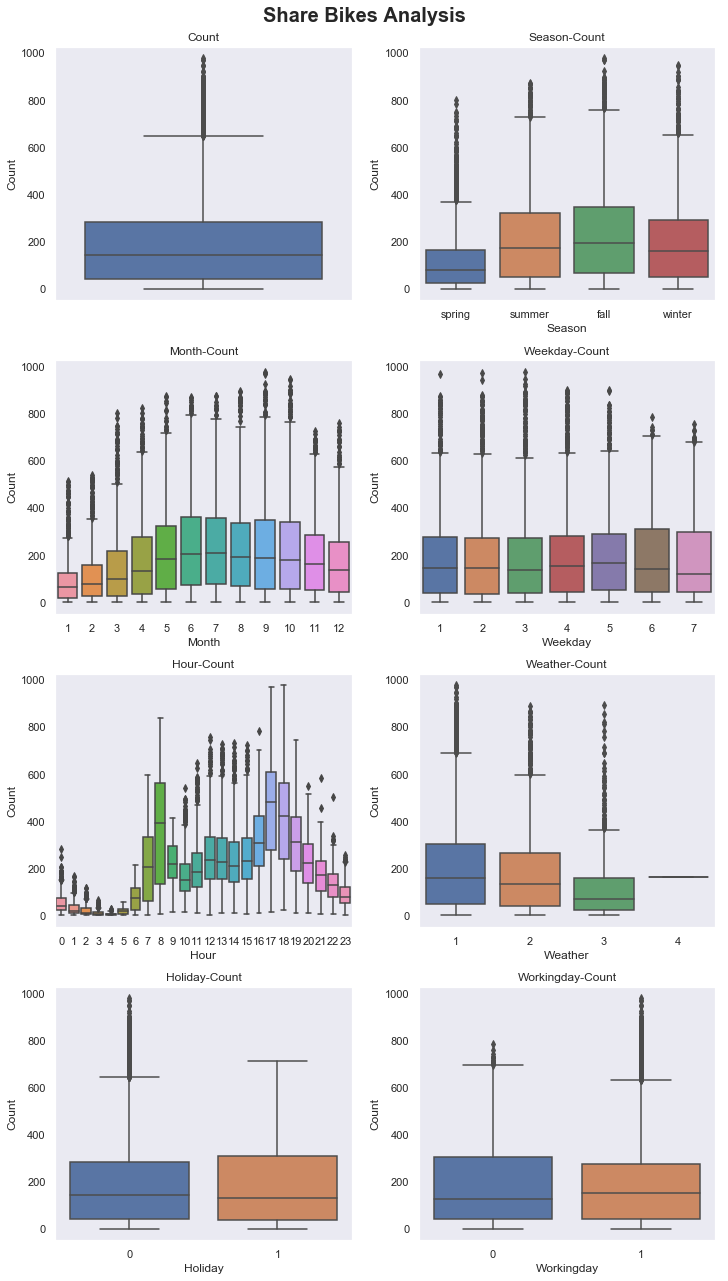

In [28]:
# 4行2列
fig, axs = plt.subplots(4, 2, constrained_layout=True)
# 图表标题
fig.suptitle('Share Bikes Analysis', fontsize=20, fontweight='bold')
# 图表大小
fig.set_size_inches(10, 18)

# 子图样式
sns.set(style='darkgrid')
# 总体租赁数量count列的箱线图
ax1 = sns.boxplot(data=bikes_clean, y='count', orient='v', ax=axs[0,0])
# 季节-租赁数量（season-count）箱线图
ax2 = sns.boxplot(data=bikes_clean, x='season_category', y='count', orient='v', ax=axs[0,1])
# 月份-租赁数量（month-count）箱线图
ax3 = sns.boxplot(data=bikes_clean, x='month', y='count', orient='v', ax=axs[1,0])
# 星期-租赁数量（weekday-count）箱线图
ax4 = sns.boxplot(data=bikes_clean, x='weekday', y='count', orient='v', ax=axs[1,1])
# 时段-租赁数量（hour-count）箱线图
ax5 = sns.boxplot(data=bikes_clean, x='hour', y='count', orient='v', ax=axs[2,0])
# 天气-租赁数量（weather-count）箱线图
ax6 = sns.boxplot(data=bikes_clean, x='weather', y='count', orient='v', ax=axs[2,1])
# 假期-租赁数量（holiday-count）箱线图
ax7 = sns.boxplot(data=bikes_clean, x='holiday', y='count', orient='v', ax=axs[3,0])
# 工作日-租赁数量（workingday-count）箱线图
ax8 = sns.boxplot(data=bikes_clean, x='workingday', y='count', orient='v', ax=axs[3,1])

# 为每个子图添加坐标和标题
axs[0,0].set(ylabel='Count', title='Count')
axs[0,1].set(xlabel = 'Season', ylabel='Count', title='Season-Count')
axs[1,0].set(xlabel = 'Month', ylabel='Count', title='Month-Count')
axs[1,1].set(xlabel = 'Weekday', ylabel='Count', title='Weekday-Count')
axs[2,0].set(xlabel = 'Hour', ylabel='Count', title='Hour-Count')
axs[2,1].set(xlabel = 'Weather', ylabel='Count', title='Weather-Count')
axs[3,0].set(xlabel = 'Holiday', ylabel='Count', title='Holiday-Count')
axs[3,1].set(xlabel = 'Workingday', ylabel='Count', title='Workingday-Count')

#plt.tight_layout()

plt.show()

**分析**：通过箱线图，明显可以看出：

- 每小时的租车人数中位数在150上下
- 夏秋季节天气温暖租车量较高
- 工作日相较于假期租车量要多一点，以及一天24小时内早高峰和晚高峰的租车量最多，说明通勤是租车的主要动机
- 显然，天气越好租车量越大

##### 2. 各离散变量对租赁数量的可视化分析

本数据集中的离散变量有：时段、月份、季节、星期，针对这些变量可观察月平均租车量、不同季节每天的平均租车量、每星期每天平均租车量、每天租车的不同用户类型。

1. **月平均租车量**
   
   分析工具与函数：
   - groupby:分组聚合
   - seaborn绘图：柱状图sns.barplot()

In [29]:
month_agg = pd.DataFrame(bikes_clean.groupby('month')['count'].mean()).reset_index()
month_agg.head()

,month,count
0,1,90.366516
1,2,110.003330
2,3,148.169811
3,4,184.160616
4,5,219.459430


In [30]:
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_agg['month_name'] = month_agg['month'].map(month_dict)
month_agg.head()

,month,count,month_name
0,1,90.366516,Jan
1,2,110.003330,Feb
2,3,148.169811,Mar
3,4,184.160616,Apr
4,5,219.459430,May


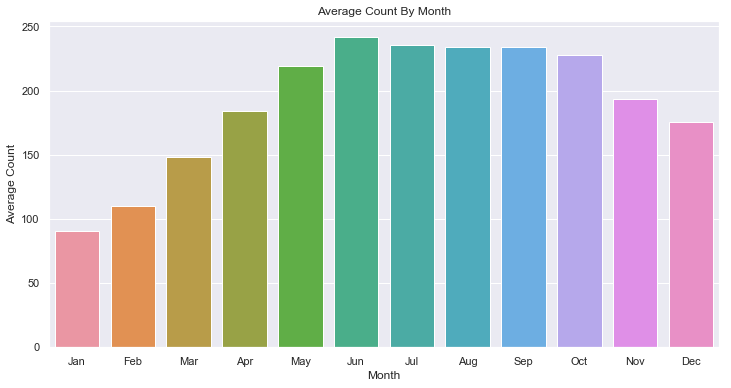

In [31]:
# 绘制月平均租车图
fig, axs = plt.subplots(figsize=(12, 6))

sns.barplot(data=month_agg, x='month_name', y='count')

axs.set(xlabel='Month', ylabel='Average Count', title="Average Count By Month")

plt.show()

**分析**：可见，6月份平均租赁数量最多。

2. **不同季节每天的平均租车量**
   
   分析工具与函数：
   - seaborn绘图：点线图sns.pointplot()
   - 用法：sns.pointplot(x=hourseason_agg\["hour"\], y=hourseason_agg\["count"\],hue=hourseason_agg\["season_word"\], data=hourseason_agg,join=True)

In [33]:
hourseason_agg = pd.DataFrame(bikes_clean.groupby(['hour', 'season_category'], sort=True)\
                              ['count'].mean()).reset_index()
hourseason_agg.head()

,hour,season_category,count
0,0,fall,75.675439
1,0,spring,28.292035
2,0,summer,58.473684
3,0,winter,57.877193
4,1,fall,44.831858


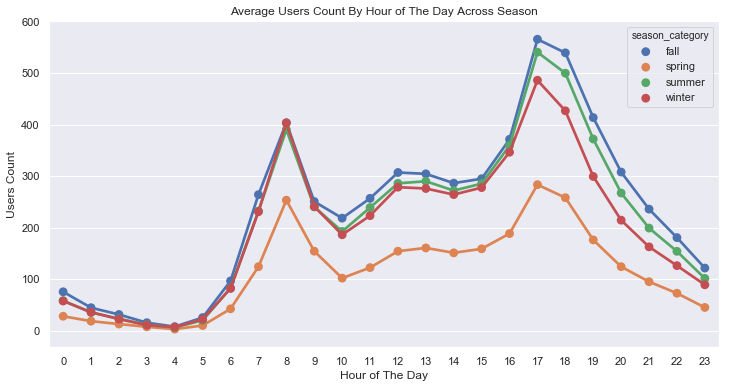

In [34]:
# 绘制不同季节每天平均租车量的点线图
fig, axs = plt.subplots(figsize=(12, 6))

sns.pointplot(x=hourseason_agg['hour'], y=hourseason_agg['count'], 
              hue=hourseason_agg['season_category'], data=hourseason_agg, join=True)

axs.set(xlabel='Hour of The Day', ylabel='Users Count',
        title="Average Users Count By Hour of The Day Across Season", label='big')

plt.show()

**分析**：可见，每天上下班时段（上午8点和下午5，6点左右）是租车的高峰期

3. **每周每天的平均租车量**
   
   分析工具与函数：同上。代码如下：

In [35]:
hourweek_agg = pd.DataFrame(bikes_clean.groupby(['hour', 'weekday'], sort=True)['count'].mean()).reset_index()
hourweek_agg.head()

,hour,weekday,count
0,0,1,35.492308
1,0,2,27.328125
2,0,3,36.246154
3,0,4,37.476923
4,0,5,53.234375


In [36]:
week_dict = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
hourweek_agg['weekday_name'] = hourweek_agg['weekday'].map(week_dict)
hourweek_agg.head()

,hour,weekday,count,weekday_name
0,0,1,35.492308,Monday
1,0,2,27.328125,Tuesday
2,0,3,36.246154,Wednesday
3,0,4,37.476923,Thursday
4,0,5,53.234375,Friday


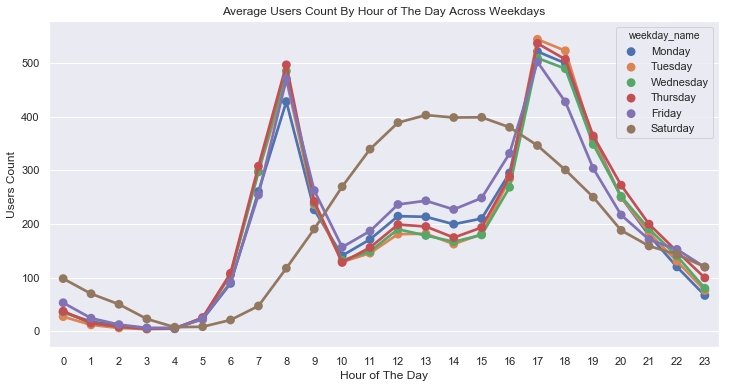

In [37]:
# 绘制每周每天的平均租车量的点线图
fig, axs = plt.subplots(figsize=(12, 6))

sns.pointplot(x=hourweek_agg['hour'], y=hourweek_agg['count'], 
              hue=hourweek_agg['weekday_name'], data=hourweek_agg, join=True)

axs.set(xlabel='Hour of The Day', ylabel='Users Count',
        title="Average Users Count By Hour of The Day Across Weekdays", label='big')

plt.show()

**分析**：工作日自行车租赁数量出现2次高峰（早8点，晚5，6点），周六基本呈正态分布。

4. **不同用户类型每天的不同时段的平均租车量**
   
   分析工具与函数：
   - melt: 数据融合。需要3个参数，分别为：
     - 需要融合的数据列表
     - 需要保留的ID变量（列），其他变量将会被融合
     - 融合而成的新变量（列）的名称
   - 用法：pandas.melt(frame, id_vars, value_vars, var_name, value_name='value', col_level)

In [38]:
hour_melted = pd.melt(bikes_clean[['hour', 'casual', 'registered']], 
                      id_vars=['hour'], var_name='user_category',
                      value_vars=['casual', 'registered'],
                      value_name='rent_count')
hour_melted.head()

,hour,user_category,rent_count
0,5,casual,0
1,10,casual,12
2,11,casual,26
3,12,casual,29
4,13,casual,47


In [40]:
houruser_agg = pd.DataFrame(hour_melted\
                            .groupby(['hour', 'user_category'], sort=True)['rent_count']\
                            .mean()).reset_index()
houruser_agg.head()

,hour,user_category,rent_count
0,0,casual,10.312088
1,0,registered,44.826374
2,1,casual,6.513216
3,1,registered,27.345815
4,2,casual,4.819196


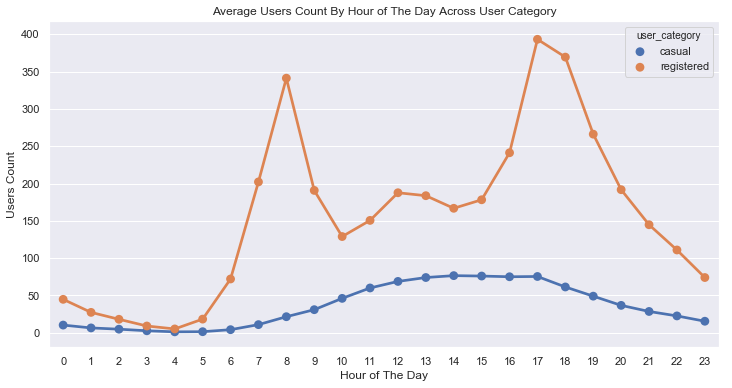

In [41]:
# 绘制不同类型用户每天不同时段的平均租车量点线图
fig, axs = plt.subplots(figsize=(12, 6))

sns.pointplot(x=houruser_agg['hour'], y=houruser_agg['rent_count'], 
              hue=houruser_agg['user_category'], 
              hue_order=['casual', 'registered'],
              data=houruser_agg, join=True)

axs.set(xlabel='Hour of The Day', ylabel='Users Count',
        title="Average Users Count By Hour of The Day Across User Category", label='big')

plt.show()

**分析**：可见，会员用户的租车数量主要集中在上下班时间段，而临时用户租车数量基本呈正太分布，而且明显要少。

##### 3. 各连续变量对租赁数量的可视化分析

连续变量：温度、湿度及风速。对于连续变量之间的关系，通常用线性回归来描述。

- 分析工具与函数：
  - seaborn.regplot：绘制线性回归图

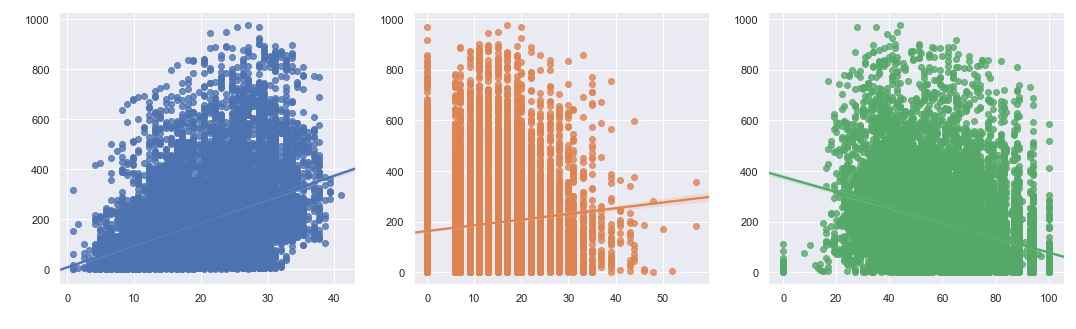

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

fig.set_size_inches(18, 5)

sns.set(style='white')
sns.despine() # 删除轴脊

ax1 = sns.regplot(x='temp', y='count', data=bikes_clean, ax=ax1)
ax2 = sns.regplot(x='windspeed', y='count', data=bikes_clean, ax=ax2)
ax3 = sns.regplot(x='humidity', y='count', data=bikes_clean, ax=ax3)

ax1.set_xlabel('temp', color='white', fontsize=15)
ax1.set_ylabel('count', color='white', fontsize=15)

ax2.set_xlabel('windspeed', color='white', fontsize=15)
ax2.set_ylabel('count', color='white', fontsize=15)

ax3.set_xlabel('humidity', color='white', fontsize=15)
ax3.set_ylabel('count', color='white', fontsize=15)

plt.show()

**分析**：可见：

- 气温低于10，高于30度，租车人数较少-太冷太热都会抑制租车需求
- 风速越大，租车人数越少-大风抑制租车需求
- 空气湿度越高，租车人数越少-干爽的天气骑车比较舒适

至此，数据可视化及分析完成。接下来从数据中提取特征便于构建模型。

### 3.5 提取特征

根据前面的可视化分析，影响租赁数量的特征有：时段（hour）、温度（temp）、湿度（humidity）、年份（year）、月份（month）、季节（season）、天气等级（weather）、风速（windspeed_rfr）、星期（weekday）、是否工作日（workingday）、是否假日（holiday）。因此，可将此11项作为特征值，同时将多类别型数据使用one-hot进行二值化处理。

In [43]:
# one-hot 编码多类别字段
month_dummies = pd.get_dummies(bikes_clean['month'], prefix='month')
season_dummies = pd.get_dummies(bikes_clean['season'], prefix='season')
weather_dummies = pd.get_dummies(bikes_clean['weather'], prefix='weather')
year_dummies = pd.get_dummies(bikes_clean['year'], prefix='year')
weekday_dummies = pd.get_dummies(bikes_clean['weekday'], prefix='weekday')
season_dummies.head()

,season_1,season_2,season_3,season_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [44]:
# 把五个新的DF和原表连接
bikes_all = pd.concat([bikes_clean, month_dummies, season_dummies, 
                       weather_dummies, year_dummies, weekday_dummies],
                      axis=1)
bikes_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,weather_4,year_2011,year_2012,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,...,0,1,0,0,0,0,0,0,1,0
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,...,0,1,0,0,0,0,0,0,1,0
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,...,0,1,0,0,0,0,0,0,1,0
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,...,0,1,0,0,0,0,0,0,1,0
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,...,0,1,0,0,0,0,0,0,1,0


去掉不需要的列，保留影响租赁数量的连续和二值化特征。

In [45]:
bikes_all.columns 

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'year', 'month', 'hour', 'weekday', 'windspeed_RFR',
       'season_category', 'weather_category', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'season_1', 'season_2', 'season_3',
       'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_2011', 'year_2012', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'],
      dtype='object')

In [46]:
drop_features = ['casual', 'registered','date', 
                 'windspeed', 'month', 'season', 'weekday',
                 'weather', 'year', 'weather_category', 'season_category', 'atemp']
bikes_ds = bikes_all.drop(drop_features, axis=1)
bikes_ds.head()

,datetime,holiday,workingday,temp,humidity,count,hour,windspeed_RFR,month_1,month_2,...,weather_4,year_2011,year_2012,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,2011-01-01 05:00:00,0,0,9.84,75,1,5,6.0032,1,0,...,0,1,0,0,0,0,0,0,1,0
1,2011-01-01 10:00:00,0,0,15.58,76,36,10,16.9979,1,0,...,0,1,0,0,0,0,0,0,1,0
2,2011-01-01 11:00:00,0,0,14.76,81,56,11,19.0012,1,0,...,0,1,0,0,0,0,0,0,1,0
3,2011-01-01 12:00:00,0,0,17.22,77,84,12,19.0012,1,0,...,0,1,0,0,0,0,0,0,1,0
4,2011-01-01 13:00:00,0,0,18.86,72,94,13,19.9995,1,0,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
bikes_features.columns

### 3.6 构建模型

#### （1）建立训练和测试数据

In [47]:
# 训练数据
bikes_train_x = bikes_ds.drop(['datetime', 'count'], axis=1) 
bikes_train_y = bikes_ds['count']
# 测试数据
bikes_test = bikes_ds.sort_values(by=['datetime'])
datetime_col = bikes_test['datetime']
bikes_test_x = bikes_test.drop(['datetime', 'count'],axis=1)
bikes_test_y = bikes_test['count']

bikes_test_x.head()

,holiday,workingday,temp,humidity,hour,windspeed_RFR,month_1,month_2,month_3,month_4,...,weather_4,year_2011,year_2012,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
9573,0,0,9.84,81,0,10.960122,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
9574,0,0,9.02,80,1,10.717803,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
9575,0,0,9.02,80,2,10.717803,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
9576,0,0,9.84,75,3,6.889752,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
9577,0,0,9.84,75,4,6.889752,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


#### （2）构建、训练及评估模型

本案例使用随机森林模型，代码如下：

In [49]:
# 建立模型
model = RandomForestRegressor(n_estimators=1000, random_state=42)
# 训练模型
model.fit(bikes_train_x, np.log(bikes_train_y))

# 预测
preds = model.predict(X = bikes_test_x)
preds.shape

(10886,)

In [51]:
# 评估模型
model.score(bikes_test_x, preds)

1.0

经评估，模型可用。

### 3.7 预测及保存结果

最后，使用测试数据将预测结果以日期时间和相应的租赁数量保存为新的数据表。

In [53]:
preds = model.predict(X = bikes_test_x)

bike_predictions = pd.DataFrame({'datetime': datetime_col, 'count': np.exp(preds)})

bike_predictions.to_csv('bike_prediction.csv', index=False)
bike_predictions.head()

,datetime,count
9573,2011-01-01 00:00:00,20.142536
9574,2011-01-01 01:00:00,29.904171
9575,2011-01-01 02:00:00,24.095806
9576,2011-01-01 03:00:00,12.572310
9577,2011-01-01 04:00:00,1.358354


In [64]:
bikes[['datetime', 'count', 'weekday']].head()

,datetime,count,weekday
0,2011-01-01 00:00:00,16,6
1,2011-01-01 01:00:00,40,6
2,2011-01-01 02:00:00,32,6
3,2011-01-01 03:00:00,13,6
4,2011-01-01 04:00:00,1,6


In [60]:
!cat bike_prediction.csv | head -n 25

datetime,count
2011-01-01 00:00:00,20.142535727328948
2011-01-01 01:00:00,29.904170561408087
2011-01-01 02:00:00,24.09580602375941
2011-01-01 03:00:00,12.572309742433763
2011-01-01 04:00:00,1.3583541868165037
2011-01-01 05:00:00,1.4603763940023218
2011-01-01 06:00:00,2.410282451973137
2011-01-01 07:00:00,5.05263805382782
2011-01-01 08:00:00,11.328813523156454
2011-01-01 09:00:00,21.529460578907315
2011-01-01 10:00:00,41.84738102991515
2011-01-01 11:00:00,58.14106982409351
2011-01-01 12:00:00,81.57423875069234
2011-01-01 13:00:00,102.94885400309838
2011-01-01 14:00:00,107.69426551055233
2011-01-01 15:00:00,101.19931130523162
2011-01-01 16:00:00,89.61446925633798
2011-01-01 17:00:00,80.62893130229398
2011-01-01 18:00:00,36.8753231436836
2011-01-01 19:00:00,36.51135972392197
2011-01-01 20:00:00,41.77362297852342
2011-01-01 21:00:00,38.780851195389616
2011-01-01 22:00:00,32.56557595655782
2011-01-01 23:00:00,44.77727456047813
cat: stdout: Broken pipe
